## Compare TPXO9 elevation with AntTG elevation (M2), Northern AP

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import make_interp_spline
from scipy.interpolate import PchipInterpolator
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
import scipy.io

import warnings
warnings.filterwarnings('ignore')

In [2]:
mat_data = scipy.io.loadmat('/g/data/nm03/lxy581/AntTG/AntTG_ocean_height_v1.mat')

In [3]:
AntTG = mat_data['AntTG']
site1 = AntTG[0, 48]

In [4]:
fields = site1.dtype.names
print("Fields:", fields)

Fields: ('site_id', 'SiteName', 'Reference', 'ShortName', 'lat', 'lon', 'RecordLength', 'DeltaTime', 'MeasType', 'amp', 'Gphase')


In [5]:
for field in site1.dtype.names:
    value = site1[field]
    # Unwrap scalar MATLAB arrays
    if value.size == 1:
        value = value[0,0]
    print(f"{field}: {value}")

site_id: 49
SiteName: ['Whalers Cove']
Reference: ['Dragani et al. (2004: Polar Geosci., 17, 156-170)']
ShortName: ['Whalers Cove']
lat: -62.983
lon: -60.567
RecordLength: 12
DeltaTime: nan
MeasType: ['06 : Visual Tide Staff']
amp: [[nan 29. nan 26. nan 46. 29. nan]]
Gphase: [[ nan  48.  nan  66.  nan 280.  nan  nan]]


In [6]:
# site_indices = [2,14,18,44,45,46,47,49,50,51,52,53,54,55,56,57,58,93,94,95,96,97,98]
# lons = []
# lats = []
# amps = []
# shortnames = []
# # Loop and extract info
# for i in site_indices:
#     site = AntTG[0, i]
#     shortname = site['ShortName'][0][0]   
#     if isinstance(shortname, (list, np.ndarray)):
#         shortname = shortname[0]
#     lon = site['lon'][0,0]
#     lat = site['lat'][0,0]
#     rec = site['RecordLength'][0][0]
#     amp = site['amp'][0,5]/100
#     # Append to lists
#     lons.append(site['lon'][0,0])
#     lats.append(site['lat'][0,0])
#     amps.append(site['amp'][0,5]/100)  # 6th amplitude value
#     shortnames.append(shortname)

#     # print(f"Site {i+1}: ShortName={shortname}, lon={lon}, lat={lat}, length={rec}, amp[5]={amp}")
    
# # Convert to NumPy arrays
# lons = np.array(lons)
# lats = np.array(lats)
# amps = np.array(amps)

In [7]:
lons = []
lats = []
recs = []
amps = []
shortnames = []

consti = 0
#M2
if consti == 0:
    amp_ind = 5
#K1    
elif consti == 1:
    amp_ind = 3

# Loop and extract info
for i in range(108):
    site = AntTG[0, i]
    
    record_len = site['RecordLength'][0,0]  
    # Skip if record length is shorter than 14 days
    if record_len < 14:
        continue
        
    # Extract ShortName
    shortname = site['ShortName'][0][0]
    if isinstance(shortname, (list, np.ndarray)):
        shortname = shortname[0]
        
    # Append to lists
    lons.append(site['lon'][0,0])
    lats.append(site['lat'][0,0])
    recs.append(site['RecordLength'][0][0])
    amps.append(site['amp'][0,amp_ind]/100)  # 6th amplitude value
    shortnames.append(shortname)

    # print(f"Site {i+1}: ShortName={shortname}, lon={lon}, lat={lat}, length={rec}, amp[5]={amp}")
    
# Convert to NumPy arrays
lons = np.array(lons)
lats = np.array(lats)
recs = np.array(recs)
amps = np.array(amps)

In [8]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')

# 8 major: M2, S2, N2, K1, O1, K2, P1, and Q1
amp_M2 = tpxo.ha.isel({'nc':0}).transpose()
amp_S2 = tpxo.ha.isel({'nc':1}).transpose()
amp_N2 = tpxo.ha.isel({'nc':2}).transpose()
amp_K2 = tpxo.ha.isel({'nc':3}).transpose()

amp_K1 = tpxo.ha.isel({'nc':4}).transpose()
amp_01 = tpxo.ha.isel({'nc':5}).transpose()
amp_P1 = tpxo.ha.isel({'nc':6}).transpose()
amp_Q1 = tpxo.ha.isel({'nc':7}).transpose()

lon_tpxo = np.array(tpgd.lon_z.transpose())
lat_tpxo = np.array(tpgd.lat_z.transpose())
hz_tpxo  = np.array(tpgd.hz.transpose())
ny, nx   = tpgd.ny.size, tpgd.nx.size

In [9]:
mz = tpgd.mz.transpose() # land mask
land_mask = 1 - (mz*0).fillna(1)

In [10]:
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), hz_tpxo),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon_tpxo),
                              'lat': (('yh', 'xh'), lat_tpxo)})
land_tpxo = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [11]:
if consti == 0:
    interp_func = RegularGridInterpolator(
        (lat_tpxo[:,0], lon_tpxo[0,:]),  # y, x
        amp_M2.values,
        bounds_error=False,
        fill_value=None  # extrapolates using nearest valid points
    )
elif consti == 1:
    interp_func = RegularGridInterpolator(
        (lat_tpxo[:,0], lon_tpxo[0,:]),  # y, x
        amp_K1.values,
        bounds_error=False,
        fill_value=None  # extrapolates using nearest valid points
    )

points_sites = np.column_stack((lats, lons))
tpxo_at_sites = interp_func(points_sites)
diff = tpxo_at_sites - amps

In [12]:
print(np.nanmin(diff),np.nanmax(diff))

-1.611 0.9342336272245364


In [13]:
start_time = time.time()

Start plotting...
0
Plotting TPXO9...
1
Plotting AntTG...
Saving...
/g/data/nm03/lxy581/evaluate/tpxo9_amp/TPXO9_AntTG_amp_Northern_AP_M2.png


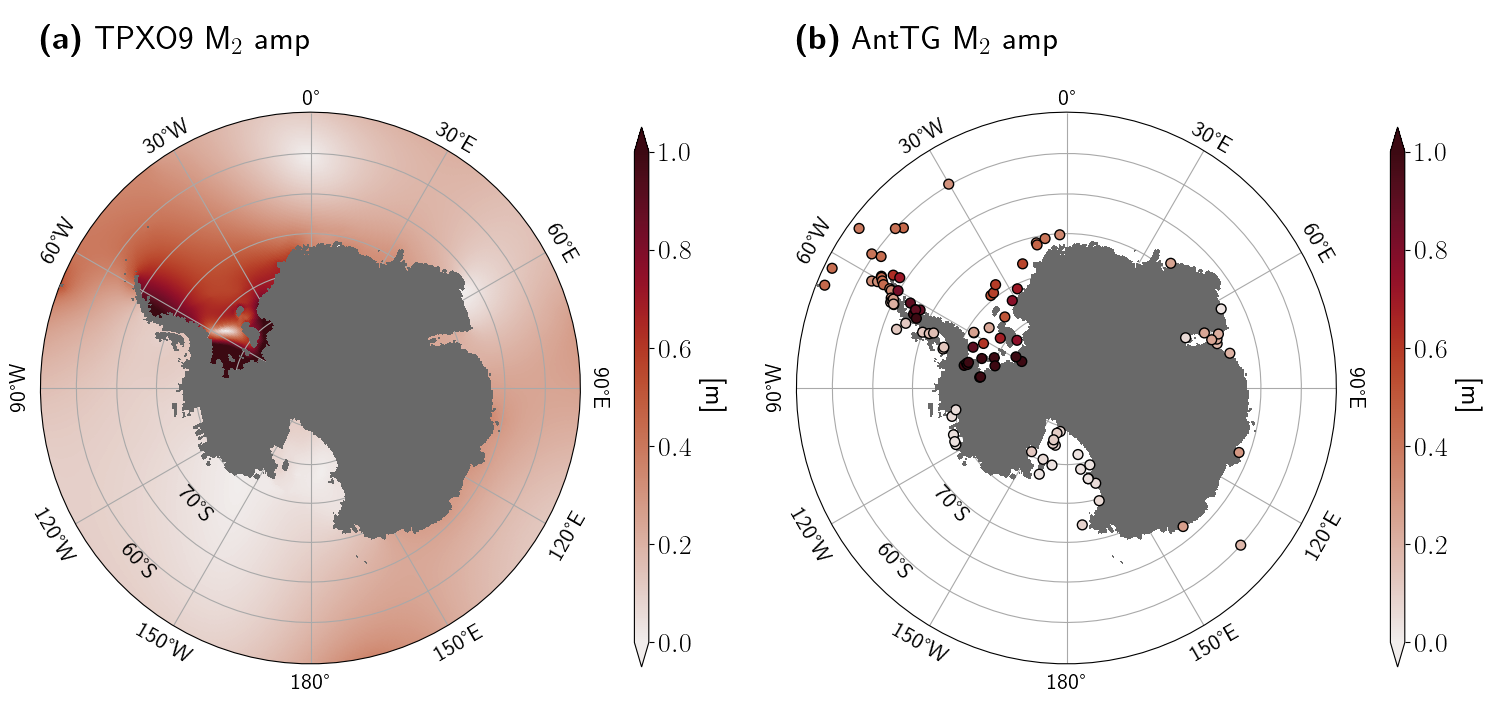

In [14]:
# Enable LaTeX text rendering
plt.rc('text', usetex=True)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as cm

fig = plt.figure(figsize=(18, 9))
axs = []

fontsize = 20
proj = ccrs.PlateCarree()

#M2
if consti == 0: 
    constit = 'M2'
    varlist = ['amp_M2', 'amps']
    title   = [r'\textbf{(a)} TPXO9 M$_2$ amp', r'\textbf{(b)} AntTG M$_2$ amp']
#K1    
elif consti == 1:
    constit = 'K1'
    varlist = ['amp_K1', 'amps']
    title   = [r'\textbf{(a)} TPXO9 K$_1$ amp', r'\textbf{(b)} AntTG K$_1$ amp']


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

gridsubs = gridspec.GridSpec(2,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, (ax, var) in enumerate(zip(axs, varlist)):
    print(I)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    
    gl = ax.gridlines(draw_labels=False, color='darkgray')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
    label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
                 '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
    rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
    lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
                     -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
    for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                                  30, -150, 150, -30]):
        ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
                horizontalalignment='center', verticalalignment='center',
                color='k', fontsize=16, transform=proj)
    for j in range(60, 90, 10):
        label = str(j) + '°S'
        ax.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
                verticalalignment='center', color='k', fontsize=16,
                transform=proj)
    ax.set_extent([-180, 180, -90, -55], proj)
    ax.set_boundary(circle, transform=ax.transAxes)

    if I==0:
        print('Plotting TPXO9...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        ax.set_position([0.1,0.1,0.3,0.72])
        ax_cb = plt.axes([0.43, 0.15, 0.008, 0.6])
        p1 = ax.pcolormesh(lon_tpxo, lat_tpxo, globals()[var], cmap=cm.cm.amp, 
                           transform=proj, vmin=0, vmax=1)
        cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left",y=1.1)

    if I==1:
        print('Plotting AntTG...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        s1 = ax.scatter(lons, lats, c=globals()[var], cmap=cm.cm.amp, vmin=0, vmax=1, s=50, 
                        edgecolors='k', transform=proj, zorder=10)
        ax.set_position([0.52,0.1,0.3,0.72])
        ax_cb = plt.axes([0.85, 0.15, 0.008, 0.6])
        cb = plt.colorbar(s1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left",y=1.1)

print('Saving...')
print('/g/data/nm03/lxy581/evaluate/tpxo9_amp/TPXO9_AntTG_amp_Northern_AP_%s.png'%constit)
# plt.savefig('/g/data/nm03/lxy581/evaluate/tpxo9_amp/TPXO9_AntTG_amp_Northern_AP_%s.png'%constit, dpi=300, bbox_inches='tight')         

In [15]:
end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f mins!" % (exe_time/60.0))

Execution time: 1.9 mins!


In [16]:
start_time = time.time()

Start plotting...
0
Plotting TPXO9...
1
Plotting AntTG...
Saving...
/g/data/nm03/lxy581/evaluate/tpxo9_amp/TPXO9_AntTG_amp_Northern_AP_diff_M2.png


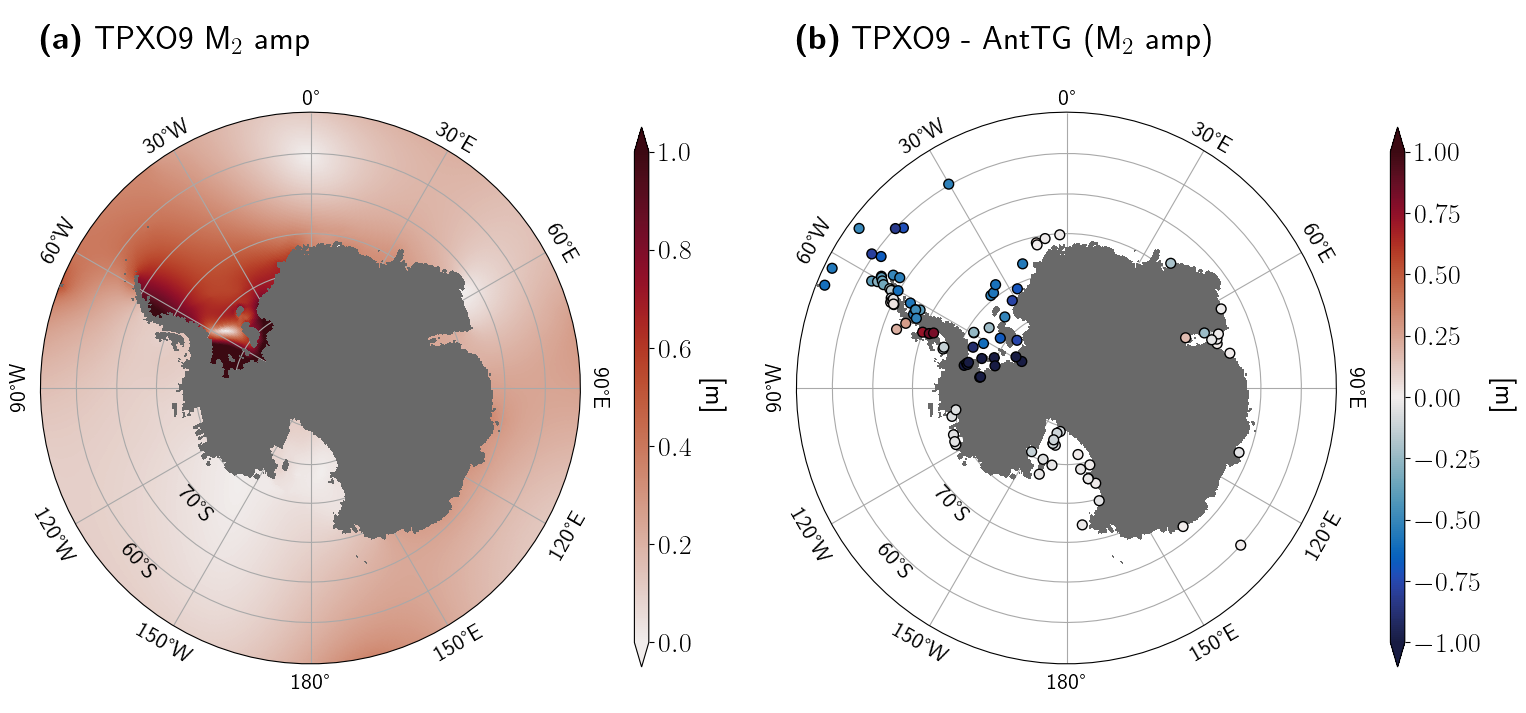

In [17]:
# Enable LaTeX text rendering
plt.rc('text', usetex=True)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as cm

fig = plt.figure(figsize=(18, 9))
axs = []

fontsize = 20
proj = ccrs.PlateCarree()
varlist = ['amp_M2', 'diff']

#M2
if consti == 0: 
    constit = 'M2'
    varlist = ['amp_M2', 'diff']
    title   = [r'\textbf{(a)} TPXO9 M$_2$ amp', r'\textbf{(b)} TPXO9 - AntTG (M$_2$ amp)']
#K1    
elif consti == 1:
    constit = 'K1'
    varlist = ['amp_K1', 'diff']
    title   = [r'\textbf{(a)} TPXO9 K$_1$ amp', r'\textbf{(b)} TPXO9 - AntTG (K$_1$ amp)']

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

gridsubs = gridspec.GridSpec(2,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

print('Start plotting...')
for I, (ax, var) in enumerate(zip(axs, varlist)):
    print(I)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    
    gl = ax.gridlines(draw_labels=False, color='darkgray')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
    label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
                 '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
    rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
    lat_lon_label = [-59.5+6, -58.7+6, -59.5+6, -58.5+6, -58.5+6, -59.2+6, -59.5+6, -59.2+6,
                     -59.5+6, -58.7+6, -58.7+6, -59.5+6] 
    for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                                  30, -150, 150, -30]):
        ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
                horizontalalignment='center', verticalalignment='center',
                color='k', fontsize=16, transform=proj)
    for j in range(60, 90, 10):
        label = str(j) + '°S'
        ax.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
                verticalalignment='center', color='k', fontsize=16,
                transform=proj)
    ax.set_extent([-180, 180, -90, -55], proj)
    ax.set_boundary(circle, transform=ax.transAxes)

    if I==0:
        print('Plotting TPXO9...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        ax.set_position([0.1,0.1,0.3,0.72])
        ax_cb = plt.axes([0.43, 0.15, 0.008, 0.6])
        p1 = ax.pcolormesh(lon_tpxo, lat_tpxo, globals()[var], cmap=cm.cm.amp, 
                           transform=proj, vmin=0, vmax=1)
        cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left",y=1.1)

    if I==1:
        print('Plotting AntTG...')
        ax.contourf(lon_tpxo,
                    lat_tpxo,
                    land_mask, colors='dimgray', levels=[0.5, 2],
                    transform=proj, rasterized=True, zorder=6)
        s1 = ax.scatter(lons, lats, c=globals()[var], cmap=cm.cm.balance, vmin=-1, vmax=1, s=50, 
                        edgecolors='k', transform=proj, zorder=10)
        ax.set_position([0.52,0.1,0.3,0.72])
        ax_cb = plt.axes([0.85, 0.15, 0.008, 0.6])
        cb = plt.colorbar(s1, cax=ax_cb, orientation='vertical', extend='both')
        cb.ax.tick_params(labelsize=fontsize)
        cb.ax.set_ylabel('[m]',rotation=270,fontsize=fontsize,labelpad=25)
        ax.set_title(title[I],fontsize=24,loc="left",y=1.1)

print('Saving...')
print('/g/data/nm03/lxy581/evaluate/tpxo9_amp/TPXO9_AntTG_amp_Northern_AP_diff_%s.png'%constit)
# plt.savefig('/g/data/nm03/lxy581/evaluate/tpxo9_amp/TPXO9_AntTG_amp_Northern_AP_diff_%s.png'%constit, dpi=300, bbox_inches='tight')         

In [18]:
end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f mins!" % (exe_time/60.0))

Execution time: 1.9 mins!
